## Import

In [3]:
import os, sys, inspect, time
"""
solve the conflict between paths, and work dir
"""
#sys.path.append('../')
#os.chdir('../')
print(sys.path)
print(os.getcwd())

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import lfi
from lfi.utils import discrepancy, visualization
from lfi.algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from lfi.detsimul import problem_GC
from lfi.utils import uos, umath

%load_ext autoreload
%autoreload 2

['/home/amaranth2/miniconda3/envs/itcff/lib/python311.zip', '/home/amaranth2/miniconda3/envs/itcff/lib/python3.11', '/home/amaranth2/miniconda3/envs/itcff/lib/python3.11/lib-dynload', '', '/home/amaranth2/miniconda3/envs/itcff/lib/python3.11/site-packages', '../']
/home/amaranth2/ITC_FF


## Problem Definition

[True posterior] pilot run 
finished pilot run: 500
finished pilot run: 1000
finished pilot run: 1500
finished pilot run: 2000
finished pilot run: 2500
finished pilot run: 3000
finished pilot run: 3500
finished pilot run: 4000
finished pilot run: 4500
finished pilot run: 5000
finished pilot run: 5500
finished pilot run: 6000
finished pilot run: 6500
finished pilot run: 7000
finished pilot run: 7500
finished pilot run: 8000
finished pilot run: 8500
finished pilot run: 9000
finished pilot run: 9500
finished pilot run: 10000
finished pilot run: 10500
finished pilot run: 11000
finished pilot run: 11500
finished pilot run: 12000
finished pilot run: 12500
finished pilot run: 13000
finished pilot run: 13500
finished pilot run: 14000
finished pilot run: 14500
finished pilot run: 15000
finished pilot run: 15500
finished pilot run: 16000
finished pilot run: 16500
finished pilot run: 17000
finished pilot run: 17500
finished pilot run: 18000
finished pilot run: 18500
finished pilot run: 19000
fini

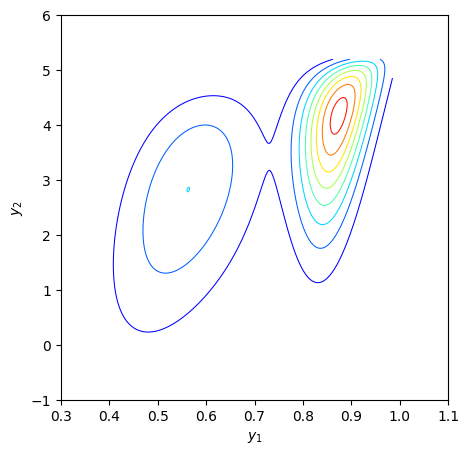

<Figure size 500x400 with 0 Axes>

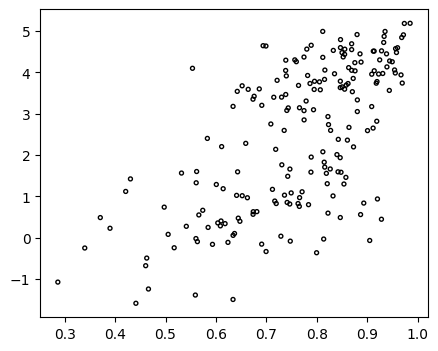

In [ ]:
DIR = 'results/FFD'                                             
RERUN = not uos.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_GC.Gaussian_Copula_Problem(N=500, n=200)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed stat
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    uos.save_object(DIR, 'data_obs', problem.data_obs)
    uos.save_object(DIR, 'y_obs', problem.y_obs)
    
    # collect samples
    true_samples = problem.sample_from_true_posterior()
    uos.save_object(DIR, 'true_samples', true_samples)
else:
    true_samples = uos.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = uos.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = uos.load_object(DIR, 'y_obs.npy')
    
## Visualize the problem
problem.visualize()
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(1,2))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,2))
plt.figure(figsize=(5,4))
visualization.plot_samples(problem.data_obs)

## Inference

### SMC

In [ ]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 2                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
uos.save_object(DIR, 'JSD_SMC', JSD_smc_array)

In [ ]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 2                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'JSD'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
uos.save_object(DIR, 'JSD_SMC2', JSD_smc2_array)

### SNL


 SNL ABC
iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  100
[sampling] finished sampling  200
[sampling] finished sampling  300
[sampling] finished sampling  400
finished: t= 0 loss= 181.28976440429688 loss val= 181.497314453125 best loss 181.497314453125
finished: t= 200 loss= -77.95915985107422 loss val= -75.26206970214844 best loss -75.5767822265625
finished: t= 400 loss= -84.09219360351562 loss val= -82.56852722167969 best loss -82.8753890991211
finished: t= 600 loss= -87.12893676757812 loss val= -85.10594177246094 best loss -85.13375854492188
finished: t= 800 loss= -87.3489761352539 loss val= -86.29930114746094 best loss -86.29930114746094
finished: t= 1000 loss= -88.82466888427734 loss val= -86.29624938964844 best loss -86.919921875
finished: t= 1200 loss= -89.64996337890625 loss val= -87.25076293945312 best loss -87.41026306152344
finished: t= 1400 loss= -88.8151168823

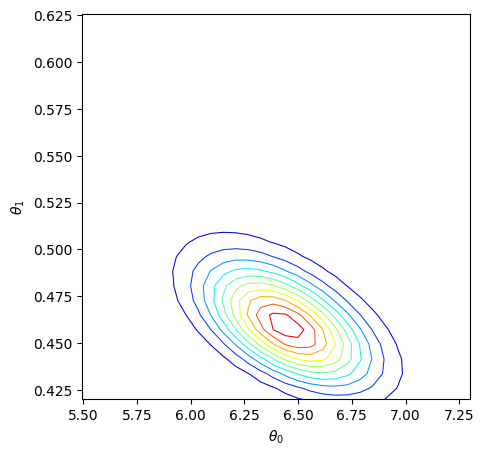

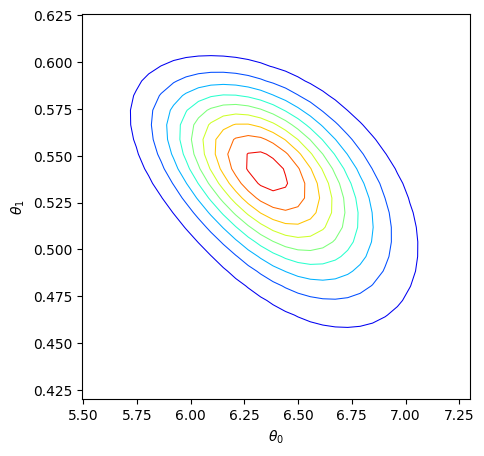

In [6]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
#hyperparams.device = 'cuda:1'
hyperparams.device = 'cpu'
hyperparams.num_sim = 4000
hyperparams.L = 2

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
uos.save_object(DIR, 'JSD_SNL', JSD_array)

In [ ]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.L = 2                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'DC'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
uos.save_object(DIR, 'JSD_SNL2', JSD_array)